In [1]:
import numpy as np
import random

class GridWorld:
    def __init__(self):
        self.grid = [
            ['S', 0, -1],
            [0, 'X', 0],
            [0, 0, 'G']
        ]
        self.start = (0, 0)
        self.goal = (2, 2)
        self.penalty = (0, 2)
        self.obstacle = (1, 1)
        self.actions = ['up', 'down', 'left', 'right']
        self.gamma = 0.9
        self.transition_prob = 0.8

    def step(self, state, action):
        if state == self.goal:
            return state, 0, True

        x, y = state
        intended_next_state = self._move(x, y, action)
        actual_next_state = self._apply_transition(intended_next_state, x, y)
        
        if actual_next_state == self.goal:
            return actual_next_state, 10, True
        elif actual_next_state == self.penalty:
            return actual_next_state, -1, False
        else:
            return actual_next_state, -0.1, False

    def _move(self, x, y, action):
        if action == 'up':
            return max(0, x - 1), y
        elif action == 'down':
            return min(2, x + 1), y
        elif action == 'left':
            return x, max(0, y - 1)
        elif action == 'right':
            return x, min(2, y + 1)

    def _apply_transition(self, intended, x, y):
        if random.random() < self.transition_prob:
            next_state = intended
        else:
            next_state = self._move(x, y, random.choice(self.actions))
        
        if next_state == self.obstacle:
            return (x, y)  # Cannot move into obstacle
        return next_state


In [2]:
def q_learning(env, episodes, alpha=0.1, epsilon=0.1):
    Q = np.zeros((3, 3, len(env.actions)))
    for episode in range(episodes):
        state = env.start
        done = False
        while not done:
            if random.random() < epsilon:
                action = random.choice(range(len(env.actions)))
            else:
                action = np.argmax(Q[state[0], state[1]])

            next_state, reward, done = env.step(state, env.actions[action])
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += alpha * (
                reward + env.gamma * Q[next_state[0], next_state[1], best_next_action] -
                Q[state[0], state[1], action]
            )
            state = next_state
    return Q


In [3]:
def sarsa(env, episodes, alpha=0.1, epsilon=0.1):
    Q = np.zeros((3, 3, len(env.actions)))
    for episode in range(episodes):
        state = env.start
        action = np.argmax(Q[state[0], state[1]]) if random.random() > epsilon else random.choice(range(len(env.actions)))
        done = False
        while not done:
            next_state, reward, done = env.step(state, env.actions[action])
            next_action = np.argmax(Q[next_state[0], next_state[1]]) if random.random() > epsilon else random.choice(range(len(env.actions)))

            Q[state[0], state[1], action] += alpha * (
                reward + env.gamma * Q[next_state[0], next_state[1], next_action] -
                Q[state[0], state[1], action]
            )
            state, action = next_state, next_action
    return Q


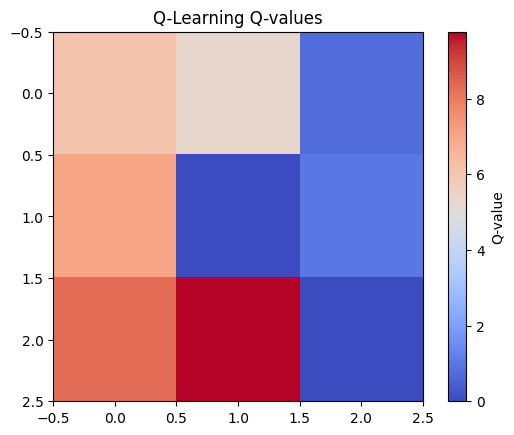

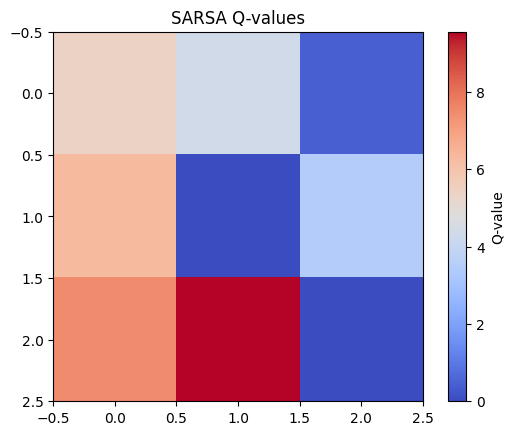

In [4]:
import matplotlib.pyplot as plt

def plot_q_values(Q, title):
    q_values = np.max(Q, axis=2)
    plt.imshow(q_values, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Q-value')
    plt.title(title)
    plt.show()

env = GridWorld()
q_learning_Q = q_learning(env, 500)
sarsa_Q = sarsa(env, 500)

plot_q_values(q_learning_Q, "Q-Learning Q-values")
plot_q_values(sarsa_Q, "SARSA Q-values")


In [5]:
def print_q_values(Q, env):
    print("\nQ-values for each state and action:")
    directions = ['↑', '↓', '←', '→']
    for i in range(3):
        for j in range(3):
            if (i, j) == env.goal:
                print(f"State {(i, j)} (Goal):")
            elif (i, j) == env.obstacle:
                print(f"State {(i, j)} (Obstacle):")
            else:
                print(f"State {(i, j)}:")
            for a, direction in enumerate(directions):
                print(f"  Action {direction}: {Q[i, j, a]:.2f}")
            print()


In [6]:
def q_learning_with_rewards(env, episodes, alpha=0.1, epsilon=0.1):
    Q = np.zeros((3, 3, len(env.actions)))
    rewards = []
    for episode in range(episodes):
        state = env.start
        done = False
        total_reward = 0  # Track total reward for the episode
        while not done:
            if random.random() < epsilon:
                action = random.choice(range(len(env.actions)))
            else:
                action = np.argmax(Q[state[0], state[1]])

            next_state, reward, done = env.step(state, env.actions[action])
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += alpha * (
                reward + env.gamma * Q[next_state[0], next_state[1], best_next_action] -
                Q[state[0], state[1], action]
            )
            total_reward += reward  # Accumulate reward
            state = next_state
        
        rewards.append(total_reward)  # Store total reward for this episode
    return Q, rewards

def sarsa_with_rewards(env, episodes, alpha=0.1, epsilon=0.1):
    Q = np.zeros((3, 3, len(env.actions)))
    rewards = []
    for episode in range(episodes):
        state = env.start
        action = np.argmax(Q[state[0], state[1]]) if random.random() > epsilon else random.choice(range(len(env.actions)))
        done = False
        total_reward = 0  # Track total reward for the episode
        while not done:
            next_state, reward, done = env.step(state, env.actions[action])
            next_action = np.argmax(Q[next_state[0], next_state[1]]) if random.random() > epsilon else random.choice(range(len(env.actions)))

            Q[state[0], state[1], action] += alpha * (
                reward + env.gamma * Q[next_state[0], next_state[1], next_action] -
                Q[state[0], state[1], action]
            )
            total_reward += reward  # Accumulate reward
            state, action = next_state, next_action
        
        rewards.append(total_reward)  # Store total reward for this episode
    return Q, rewards


Q-Learning Q-values:

Q-values for each state and action:
State (0, 0):
  Action ↑: -0.11
  Action ↓: 6.39
  Action ←: 1.08
  Action →: 0.20

State (0, 1):
  Action ↑: 0.03
  Action ↓: -0.20
  Action ←: 2.23
  Action →: -0.25

State (0, 2):
  Action ↑: -0.10
  Action ↓: 0.43
  Action ←: -0.02
  Action →: -0.10

State (1, 0):
  Action ↑: 0.15
  Action ↓: 7.52
  Action ←: 1.84
  Action →: 1.59

State (1, 1) (Obstacle):
  Action ↑: 0.00
  Action ↓: 0.00
  Action ←: 0.00
  Action →: 0.00

State (1, 2):
  Action ↑: -0.10
  Action ↓: 3.41
  Action ←: 0.00
  Action →: 0.00

State (2, 0):
  Action ↑: 0.74
  Action ↓: 1.34
  Action ←: 2.05
  Action →: 8.56

State (2, 1):
  Action ↑: 1.70
  Action ↓: 1.57
  Action ←: 2.11
  Action →: 9.66

State (2, 2) (Goal):
  Action ↑: 0.00
  Action ↓: 0.00
  Action ←: 0.00
  Action →: 0.00

SARSA Q-values:

Q-values for each state and action:
State (0, 0):
  Action ↑: -0.09
  Action ↓: 4.63
  Action ←: 0.56
  Action →: -0.00

State (0, 1):
  Action ↑: -0.15


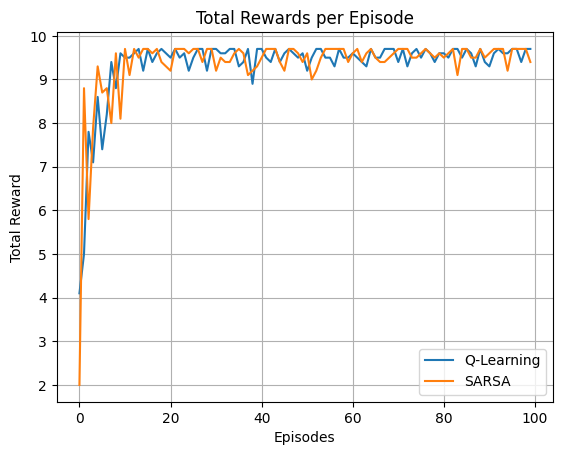

In [7]:
def plot_rewards(rewards_q, rewards_sarsa):
    plt.plot(rewards_q, label="Q-Learning")
    plt.plot(rewards_sarsa, label="SARSA")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Total Rewards per Episode")
    plt.legend()
    plt.grid()
    plt.show()

# 실행
env = GridWorld()
episodes = 100

q_learning_Q, rewards_q_learning = q_learning_with_rewards(env, episodes)
sarsa_Q, rewards_sarsa = sarsa_with_rewards(env, episodes)

print("Q-Learning Q-values:")
print_q_values(q_learning_Q, env)

print("SARSA Q-values:")
print_q_values(sarsa_Q, env)

plot_rewards(rewards_q_learning, rewards_sarsa)


q랑 v는 비슷한데 v는 해당 스테이트에서 기대되는 일정의 값이고, q는 action value 해당 스테이트에서 어떤 액션을 했을 때 받는 value
다인나믹 프로그래믹은 환경을 알 때고 이를 환경 베이스, 환경 모르면 모델 베이스, 모델 베이스면 어떤 a를 그냥 취하고 r, s'을 보고 테이블을 완성함
behaviour policy랑 target policy가 다르면 off policy=q-learning 같으면 on policy=sarsa

1-alfa : alfa가 0.7이면 현재 값에 0.3 만큼 유지
입실론 그리디 : 입실론 만큼 랜덤으로 선택
